In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# text 데이터 컬럼에 true인 사전 생성
def make_choice_dic(data, columne_name):
    choice_list = [False for i in range(len(columne_name))]
    lenpriorlist = []
    for name in columne_name:
        lencolone = len(data[name][0])
        lenpriorlist.append(lencolone)
    true_index = lenpriorlist.index(max(lenpriorlist))
    choice_list[true_index] = True
    choice_dic = {name : value for name, value in zip(columne_name, choice_list)}
    return choice_dic

# 데이터 중복 제거 및 Null값 제거
def cut_dup_null(data, columne_name, choice_dic):
    print('전체 샘플수 :', len(data))
    for name in columne_name:
        if choice_dic[name]:
            data.drop_duplicates(subset = name, inplace=True)
        data.replace('', np.nan, inplace=True)
        data.dropna(axis=0, inplace=True)
    print('전처리 이후 샘플수 :', len(data))
    return data

# 불용어 삭제 및 텍스트 정규화
def cut_stopword(data, columne_name, choice_dic, contractions):
    def preprocess_sentence(sentence, remove_stopwords):
        sentence = sentence.lower()
        sentence = BeautifulSoup(sentence, "lxml").text
        sentence = re.sub(r'\([^)]*\)', '', sentence)
        sentence = re.sub('"','', sentence)
        sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])
        sentence = re.sub(r"'s\b","", sentence)
        sentence = re.sub("[^a-zA-Z]", " ", sentence)
        sentence = re.sub('[m]{2,}', 'mm', sentence)
        
        if remove_stopwords:
            tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
            
        else:
            tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
            
        return tokens
    
    return_data = []
    for name in columne_name:
        return_col = []
        for seq in data[name]:
            tokens = preprocess_sentence(seq, choice_dic[name])
            return_col.append(tokens)
        return_data.append(return_col)
        
    for i, name in enumerate(columne_name):
        data[name] = return_data[i]
        
    data.replace('', np.nan, inplace=True)
    data.dropna(axis=0, inplace=True)
        
    return data

# 샘플 길이 결정을 위한 시각화 함수
def visual_len(data, columne_name, choice_dic):
    for name in columne_name:
        if choice_dic[name]:
            text_len = [len(s.split()) for s in data[name]]
        else:
            summary_len = [len(s.split()) for s in data[name]]
        
    print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
    print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
    print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
    print('텍스트의 길이 분산 : {}'.format(np.var(text_len)))
    print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
    print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
    print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))
    print('요약의 길이 분산 : {}'.format(np.var(summary_len)))
    
    plt.title('Text')
    plt.hist(text_len, bins = 40)
    plt.xlabel('length of samples')
    plt.ylabel('number of samples')
    plt.show()
    
    plt.title('Summary')
    plt.hist(summary_len, bins = 40)
    plt.xlabel('length of samples')
    plt.ylabel('number of samples')
    plt.show()

def per_len(data, choice_dic, max_len, wich_data=True):
    reverce_choice_dic = {v:k for k,v in choice_dic.items()}
    target_col = reverce_choice_dic[wich_data]
    
    cnt = 0
    
    for seq in data[target_col]:
        if (len(seq.split()) <= max_len):
            cnt = cnt + 1
    
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(data[target_col]))))
    
    return


def cut_long(data, columne_name, choice_dic, max_len, sub_max_len):
    return_list = []
    
    for name in columne_name:
        return_col = []
        cut_len = 0
        if choice_dic[name]:
            cut_len = max_len
        else:
            cut_len = sub_max_len
        for seq in data[name]:
            if len(seq.split()) > cut_len :
                return_seq = ''
            else :
                return_seq = seq
            return_col.append(return_seq)
        return_list.append(return_col)
        
    for i, name in enumerate(columne_name):
        data[name] = return_list[i]
        
    data.replace('', np.nan, inplace=True)
    data.dropna(axis=0, inplace=True)
    
    len_list = [max_len, sub_max_len]
    
    print('길이 처리 이후 샘플 수 :', (len(data)))
    
    return data, len_list


def add_token_split(data, columne_name, choice_dic, spilt_rate = 0.8, surffle = True):
    reverce_choice_dic = {v:k for k,v in choice_dic.items()}
    text_col = reverce_choice_dic[True]
    target_col = reverce_choice_dic[False]
    
    data['decoder_input'] = data[target_col].apply(lambda x : 'sostoken '+ x)
    data['decoder_target'] = data[target_col].apply(lambda x : x + ' eostoken')
    
    encoder_input = np.array(data[text_col])
    decoder_input = np.array(data['decoder_input'])
    decoder_target = np.array(data['decoder_target'])
    
    if surffle == True :
        indices = np.arange(encoder_input.shape[0])
        np.random.shuffle(indices)
        
        encoder_input = encoder_input[indices]
        decoder_input = decoder_input[indices]
        decoder_target = decoder_target[indices]
        
    n_of_val = int(len(encoder_input)*spilt_rate)
    
    encoder_input_train = encoder_input[:-n_of_val]
    decoder_input_train = decoder_input[:-n_of_val]
    decoder_target_train = decoder_target[:-n_of_val]
    
    encoder_input_test = encoder_input[-n_of_val:]
    decoder_input_test = decoder_input[-n_of_val:]
    decoder_target_test = decoder_target[-n_of_val:]
    
    seq2seq_data = [encoder_input_train, decoder_input_train, decoder_target_train, 
                    encoder_input_test, decoder_input_test, decoder_target_test]
    
    return seq2seq_data

In [3]:
def check_voca_rate(seq2seq_data, e_word, d_word):
    src_tokenizer = Tokenizer()
    src_tokenizer.fit_on_texts(seq2seq_data[0])
    
    tar_tokenizer = Tokenizer()
    tar_tokenizer.fit_on_texts(seq2seq_data[1])
    
    name_list = ['텍스트', '요약']
    word_num_list = [e_word, d_word]
    tokenizer_list = [src_tokenizer.word_index, tar_tokenizer.word_index]
    tokenizer_word_list = [src_tokenizer.word_counts.items(), tar_tokenizer.word_counts.items()]
    
    for name, num, tok, toki in zip(name_list, word_num_list, tokenizer_list, tokenizer_word_list):
        threshold = num
        total_cnt = len(tok)
        rare_cnt = 0
        total_freq = 0
        rare_freq = 0
        
        for key, value in toki:
            total_freq = total_freq + value
            if(value < threshold):
                rare_cnt = rare_cnt + 1
                rare_freq = rare_freq + value
            
        print(name + ' 단어 집합(vocabulary)의 크기 :', total_cnt)
        print(name + ' 등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
        print(name + ' 단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
        print(name + " 단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
        print(name + " 전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

        
def encoding_voca(seq2seq_data, src_vocab, tar_vocab, len_list, padding_pyte='pre'):
    src_tokenizer = Tokenizer(num_words=src_vocab)
    src_tokenizer.fit_on_texts(seq2seq_data[0])
    
    tar_tokenizer = Tokenizer(tar_vocab)
    tar_tokenizer.fit_on_texts(seq2seq_data[1])
    tar_tokenizer.fit_on_texts(seq2seq_data[2])
    
    seq2seq_data[0] = src_tokenizer.texts_to_sequences(seq2seq_data[0])
    seq2seq_data[3] = src_tokenizer.texts_to_sequences(seq2seq_data[3])
    seq2seq_data[1] = tar_tokenizer.texts_to_sequences(seq2seq_data[1])
    seq2seq_data[2] = tar_tokenizer.texts_to_sequences(seq2seq_data[2])
    seq2seq_data[4] = tar_tokenizer.texts_to_sequences(seq2seq_data[4])
    seq2seq_data[5] = tar_tokenizer.texts_to_sequences(seq2seq_data[5])
    
    drop_train = [index for index, sentence in enumerate(seq2seq_data[1]) if len(sentence) == 1]
    drop_test = [index for index, sentence in enumerate(seq2seq_data[4]) if len(sentence) == 1]
    
    seq2seq_data[0] = [sentence for index, sentence in enumerate(seq2seq_data[0]) if index not in drop_train]
    seq2seq_data[1] = [sentence for index, sentence in enumerate(seq2seq_data[1]) if index not in drop_train]
    seq2seq_data[2] = [sentence for index, sentence in enumerate(seq2seq_data[2]) if index not in drop_train]
    
    seq2seq_data[3] = [sentence for index, sentence in enumerate(seq2seq_data[3]) if index not in drop_test]
    seq2seq_data[4] = [sentence for index, sentence in enumerate(seq2seq_data[4]) if index not in drop_test]
    seq2seq_data[5] = [sentence for index, sentence in enumerate(seq2seq_data[5]) if index not in drop_test]
    
    seq2seq_data[0] = pad_sequences(seq2seq_data[0], maxlen=len_list[0], padding=padding_pyte)
    seq2seq_data[3] = pad_sequences(seq2seq_data[3], maxlen=len_list[0], padding=padding_pyte)
    seq2seq_data[1] = pad_sequences(seq2seq_data[1], maxlen=len_list[1], padding=padding_pyte)
    seq2seq_data[2] = pad_sequences(seq2seq_data[2], maxlen=len_list[1], padding=padding_pyte)
    seq2seq_data[4] = pad_sequences(seq2seq_data[4], maxlen=len_list[1], padding=padding_pyte)
    seq2seq_data[5] = pad_sequences(seq2seq_data[5], maxlen=len_list[1], padding=padding_pyte)
    
    voca_num = [src_vocab, tar_vocab]
    
    return seq2seq_data, voca_num, src_tokenizer, tar_tokenizer

def decode_sequence(encoder_model, decoder_model, input_seq, tar_tokenizer, summary_max_len):
    tar_word_to_index = tar_tokenizer.word_index
    tar_index_to_word = tar_tokenizer.index_word
    
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:        
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]
        
        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token
            
        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True
            
        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        
        # 상태를 업데이트 합니다.
        e_h, e_c = h, c
        
    return decoded_sentence


def seq2text(input_seq, src_tokenizer):
    src_index_to_word = src_tokenizer.index_word
    
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

def seq2summary(input_seq, tar_tokenizer):
    tar_index_to_word = tar_tokenizer.index_word
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + tar_index_to_word[i]+' '
    return temp

## 데이터 import 및 전처리

### 데이터 import

In [4]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data0 = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

### 불용어 및 정규화 사전 생성

In [5]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
print("정규화 사전의 수: ", len(contractions))
print('불용어 개수 :', len(stopwords.words('english') ))

정규화 사전의 수:  120
불용어 개수 : 179


### 데이터 전처리(불용어, 정규화, 중복값, 결측값)

In [6]:
columne_name = ['text', 'headlines']

choice_dic = make_choice_dic(data0, columne_name)

data1 = data0

data1 = cut_dup_null(data1, columne_name, choice_dic)

data2 = data1

data2 = cut_stopword(data2, columne_name, choice_dic, contractions)

전체 샘플수 : 98401
전처리 이후 샘플수 : 98360


### 데이터 분할 및 텍스트 길이 설정

- 텍스트 길이를 설정하기 위해 분포 확인

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
텍스트의 길이 분산 : 14.435335402905325
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534
요약의 길이 분산 : 1.932362530369967


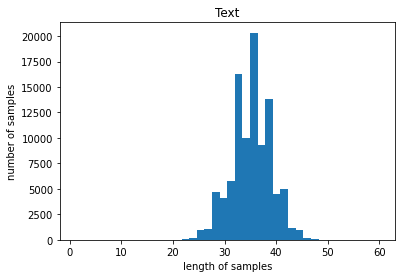

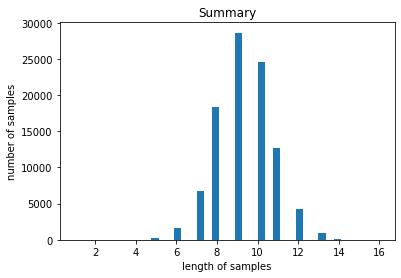

In [7]:
visual_len(data2, columne_name, choice_dic)

In [8]:
per_len(data2, choice_dic, 38, True)
per_len(data2, choice_dic, 10, False)

전체 샘플 중 길이가 38 이하인 샘플의 비율: 0.8163379422529483
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.8162972753151687


- 위에서 확인한 분포 기반으로 길이 설정

In [9]:
data3 = data2
data3, len_list = cut_long(data3, columne_name, choice_dic, 38, 10)

길이 처리 이후 샘플 수 : 65295


- 데이터 분할 및 토큰화, 패딩

In [10]:
seq2seq_data = add_token_split(data3, columne_name, choice_dic, 0.2)

In [11]:
print(seq2seq_data[0].shape)
print(seq2seq_data[3].shape)

(52236,)
(13059,)


- 데이터 사전에 드문 데이터 제거

In [12]:
check_voca_rate(seq2seq_data, 7, 6)

텍스트 단어 집합(vocabulary)의 크기 : 57574
텍스트 등장 빈도가 6번 이하인 희귀 단어의 수: 39683
텍스트 단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 17891
텍스트 단어 집합에서 희귀 단어의 비율: 68.92520929586271
텍스트 전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.547880954718689
요약 단어 집합(vocabulary)의 크기 : 25850
요약 등장 빈도가 5번 이하인 희귀 단어의 수: 17411
요약 단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8439
요약 단어 집합에서 희귀 단어의 비율: 67.35396518375242
요약 전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.483525261006699


In [13]:
seq2seq_data, voca_num, src_tokenizer, tar_tokenizer = encoding_voca(seq2seq_data, 18000, 8000, len_list)

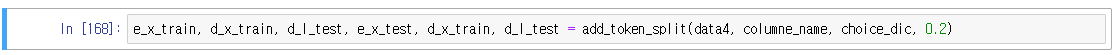
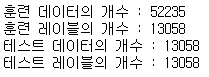
- 변수명으로 인하여 지속적으로 오류가 있었음

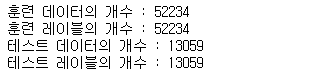
(정상 결과)


- 변수를 리스트로 함축하여 함수에 넣을 수 있다면 수정이 더 편이할 것

## 모델 구축 및 모델 학습

In [14]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import AdditiveAttention

### 모델 구축

- 3층 구조 인코더 구조 구축
    - src_voca 및 max_len 값은 위에서 전처리 과정중 모두 저장해 둘 수 있게 해두었음
    
- 단일층 디코더 구조 구축
    - tar_vocab도 위 내용과 동일 준비하였음

- 어텐션 층 구축

In [15]:
embedding_dim = 128
hidden_size = 256
src_vocab = voca_num[0]
tar_vocab = voca_num[1]
text_max_len = len_list[0]
summary_max_len = len_list[0]

In [16]:
e_x_train = seq2seq_data[0]
d_x_train = seq2seq_data[1]
d_l_train = seq2seq_data[2]
e_x_test = seq2seq_data[3]
d_x_test = seq2seq_data[4]
d_l_test = seq2seq_data[5]

In [17]:
# 인코더
encoder_inputs = Input(shape=(text_max_len,))
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

In [18]:
# 디코더
decoder_inputs = Input(shape=(None,))

dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [19]:
# 어텐션 층
attn_layer = AdditiveAttention(name='attention_layer')

attn_out = attn_layer([decoder_outputs, encoder_outputs])

decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

In [20]:
# 디코더 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 38, 128)      2304000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 38, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

- 추론 모델에서 추론이 안되는 문제가 발생
    - 어텐션이 적용되지 않은 모델을 정의하고 있었음
    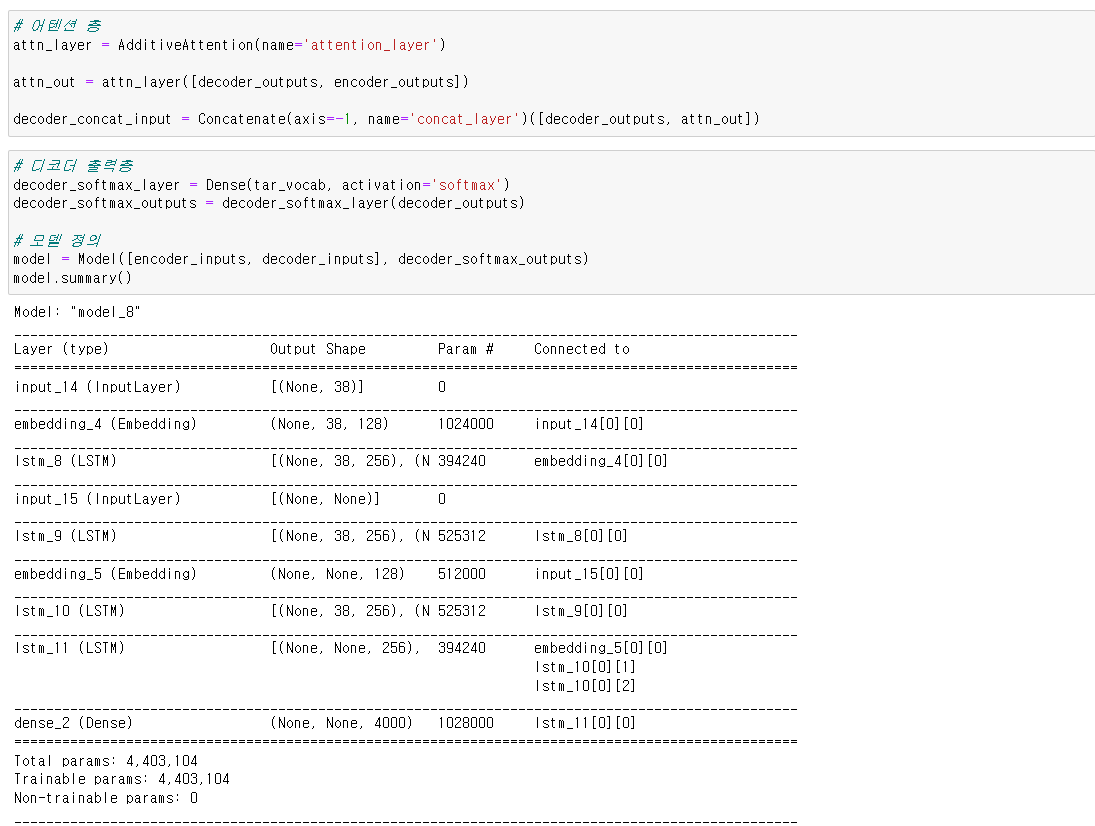
    (수정전)
    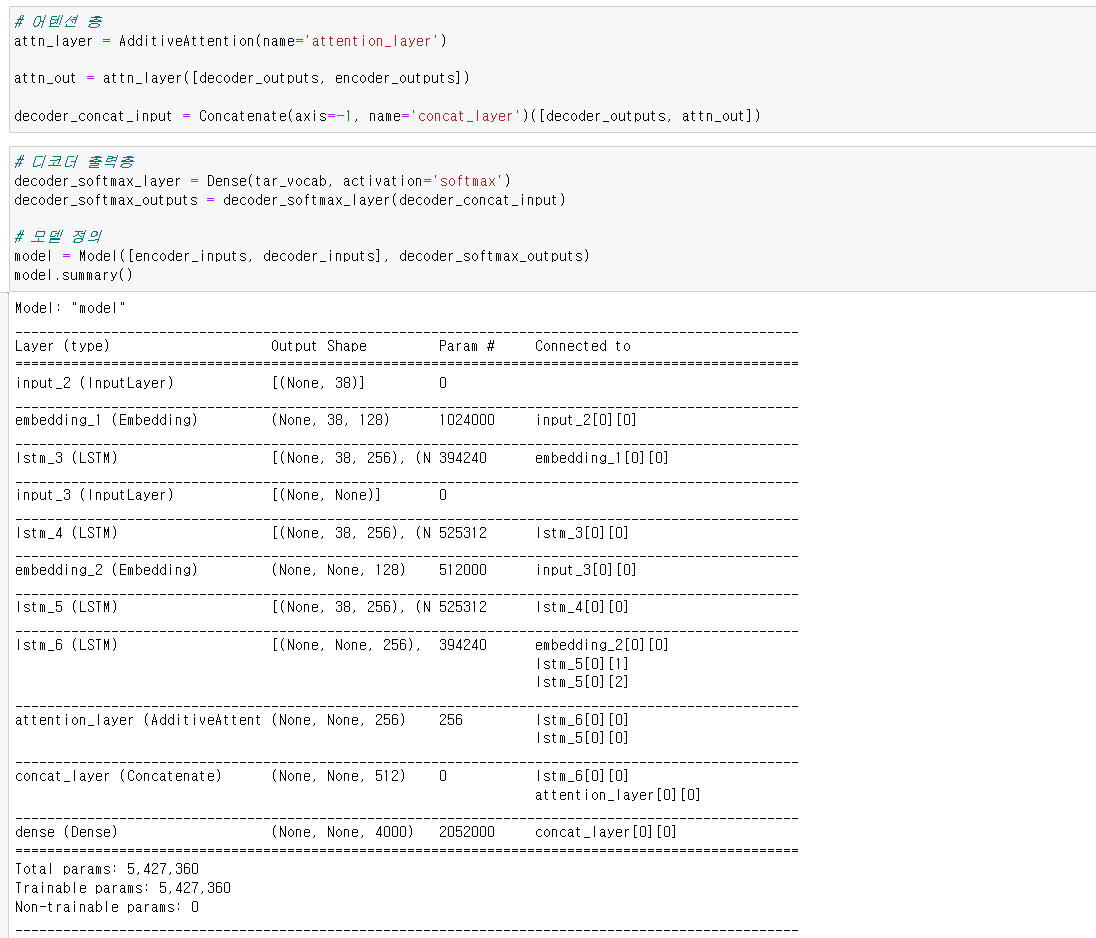
    (수정후)

### 모델 학습

In [21]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[e_x_train, d_x_train], y=d_l_train, \
          validation_data=([e_x_test, d_x_test], d_l_test), \
          batch_size=256, epochs=30)

Epoch 1/30
205/205 [==============================] - 23s 77ms/step - loss: 6.1637 - val_loss: 5.8114
Epoch 2/30
205/205 [==============================] - 15s 72ms/step - loss: 5.8037 - val_loss: 5.6778
Epoch 3/30
205/205 [==============================] - 15s 73ms/step - loss: 5.6195 - val_loss: 5.5150
Epoch 4/30
205/205 [==============================] - 15s 74ms/step - loss: 5.3706 - val_loss: 5.2301
Epoch 5/30
205/205 [==============================] - 15s 76ms/step - loss: 5.1150 - val_loss: 5.0420
Epoch 6/30
205/205 [==============================] - 16s 77ms/step - loss: 4.8954 - val_loss: 4.9163
Epoch 7/30
205/205 [==============================] - 16s 77ms/step - loss: 4.6971 - val_loss: 4.7715
Epoch 8/30
205/205 [==============================] - 16s 76ms/step - loss: 4.5193 - val_loss: 4.6644
Epoch 9/30
205/205 [==============================] - 16s 76ms/step - loss: 4.3608 - val_loss: 4.5850
Epoch 10/30
205/205 [==============================] - 16s 76ms/step - loss: 4.217

- 결과 확인

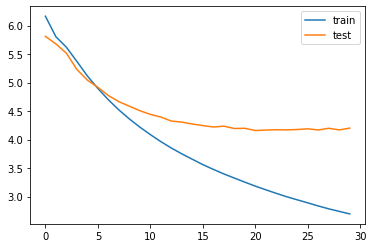

In [22]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 추론 모델 제작

### 모델 구축

In [23]:
# 인코더
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

In [24]:
# 디코더
# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

# 디코더 층 (출력 문장에 길이에 따른 반복 구조를 위함)
dec_emb2 = dec_emb_layer(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [25]:
# 어텐션 층
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

In [26]:
# 디코더 출력
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 모델 정의
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

### 추론 모델 구동

In [28]:
for i in range(50, 100):
    print("원문 :", seq2text(e_x_test[i], src_tokenizer))
    print("실제 요약 :", seq2summary(d_x_test[i], tar_tokenizer))
    print("예측 요약 :", decode_sequence(encoder_model, decoder_model, e_x_test[i].reshape(1, text_max_len), tar_tokenizer, summary_max_len))
    print("\n")

원문 : tourism minister kj alphons thursday said forcing foreigners take selfies right thing intrusion privacy referring recent attack swiss couple fatehpur sikri minister questioned leave tourists alone obsessed white skin 
실제 요약 : sostoken asking foreigners for selfies of privacy minister 
예측 요약 :  no plans to clean people for not it minister


원문 : hollywood actor james franco digitally removed cover vanity fair annual hollywood issue sexual harassment allegations confirmed magazine spokesperson franco originally positioned michael shannon harrison ford cover actor accused sexually behaviour five women 
실제 요약 : sostoken removed from fair cover over sexual harassment 
예측 요약 :  comedian accuses singer of sexual harassment by sexual harassment


원문 : year old girl allegedly gang raped three four accused men thrown drain jharkhand friday girl returning home maternal uncle residence alone accused started following committed crime girl rescued drain screamed help consciousness 
실제 요약 : girl

예측 요약 :  facebook to shut down by amazon in india report


원문 : former kingfisher airlines employee said vijay mallya first consider plight undergone employees think little bit humanity left within first clear dues stated way honours enjoys watching indian matches similarly honour indian judiciary run away added 
실제 요약 : sostoken mallya should clear staff dues first ex kingfisher employee 
예측 요약 :  india to be force india to london board chief


원문 : afghanistan cricket board announced first ever afghanistan premier league take place uae october year tournament played five teams auction purchase teams held march many non afghan cricketers expressed interest participating tournament 
실제 요약 : sostoken afghanistan launches its own league 
예측 요약 :  afghanistan afghan team to test for afghan in afghanistan


원문 : case registered shopkeeper town madhya pradesh district allegedly refusing accept coins shopkeeper charged order public servant complaint filed man offered shopkeeper two coins buy

예측 요약 :  elon musk to build people in space in paris


원문 : india judges per lakh people average according data law ministry states lower courts shortage judicial officers high courts currently vacancies meanwhile supreme court sanctioned strength judges six vacancies nnnn 
실제 요약 : sostoken india has judges per lakh people law ministry data 
예측 요약 :  india to increase in cases of in years cases


원문 : uber fired eric alexander president uber business asia pacific accessing medical records woman raped ride india according carried information year shared ceo travis kalanick alexander view rape incident competitor ola work 
실제 요약 : sostoken uber fires man for indian rape victim records 
예측 요약 :  uber sued for crore in uber ride for product


원문 : actress pooja bhatt shared post social media mark eight months quitting alcohol said quit drinking christmas last year earlier pooja said stopped drinking first acknowledging drinking problem adding daughter alcoholic makes four times becoming on

- 패딩으로 인하여 원문이 안나오는 상황이 발생함
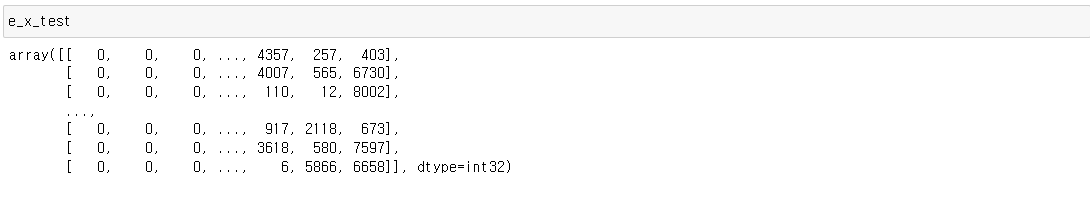
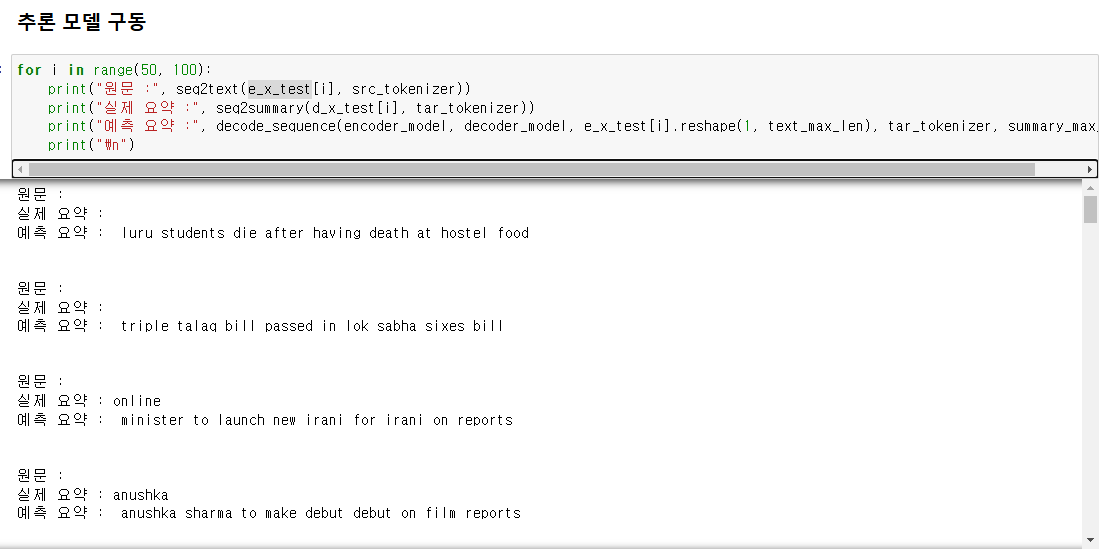

- 확인해보니 패딩의 문제가 아니라 함수의 return 위치가 잘 못 되었음
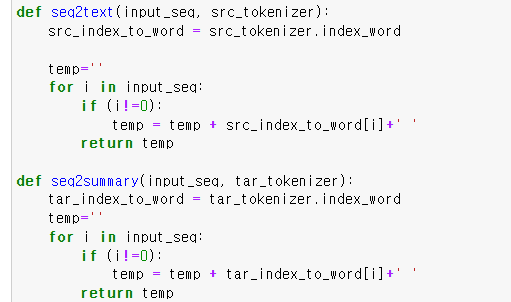

## summa 추출적 요약

In [29]:
from summa.summarizer import summarize

In [33]:
data_s = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [34]:
summa_data = []

for seq in data_s['text']:
    sigle_summa_data = summarize(seq, words=10)
    summa_data.append(sigle_summa_data)

In [35]:
data_s['summa'] = summa_data

data_s.head()

,headlines,text,summa
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",upGrad's Online Power Learning has powered 3 l...
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...,
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...,The match witnessed India getting all out for ...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...",
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...,


## 추가 실험

- 다층 디코더 구조

- 모델 구축 (최종 context가 각 디코더 층에 전해지도록)

In [36]:
# 인코더
encoder_inputs = Input(shape=(text_max_len,))
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

In [37]:
# 디코더
decoder_inputs = Input(shape=(None,))

dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs1, _, _ = decoder_lstm1(dec_emb, initial_state=[state_h, state_c])

decoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs2, _, _ = decoder_lstm2(decoder_outputs1, initial_state=[state_h, state_c])

decoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm3(decoder_outputs2, initial_state=[state_h, state_c])

In [38]:
# 어텐션 층
attn_layer = AdditiveAttention(name='attention_layer')

attn_out = attn_layer([decoder_outputs, encoder_outputs])

decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

In [39]:
# 디코더 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 38, 128)      2304000     input_6[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 38, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [40]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[e_x_train, d_x_train], y=d_l_train, \
          validation_data=([e_x_test, d_x_test], d_l_test), \
          batch_size=256, epochs=30)

Epoch 1/30
205/205 [==============================] - 28s 94ms/step - loss: 6.2507 - val_loss: 5.8493
Epoch 2/30
205/205 [==============================] - 17s 85ms/step - loss: 5.8472 - val_loss: 5.7026
Epoch 3/30
205/205 [==============================] - 17s 84ms/step - loss: 5.7116 - val_loss: 5.6302
Epoch 4/30
205/205 [==============================] - 17s 83ms/step - loss: 5.5658 - val_loss: 5.4885
Epoch 5/30
205/205 [==============================] - 17s 85ms/step - loss: 5.3629 - val_loss: 5.2774
Epoch 6/30
205/205 [==============================] - 17s 85ms/step - loss: 5.1043 - val_loss: 5.0764
Epoch 7/30
205/205 [==============================] - 17s 84ms/step - loss: 4.9053 - val_loss: 4.9754
Epoch 8/30
205/205 [==============================] - 17s 84ms/step - loss: 4.7418 - val_loss: 4.9277
Epoch 9/30
205/205 [==============================] - 17s 84ms/step - loss: 4.5927 - val_loss: 4.8129
Epoch 10/30
205/205 [==============================] - 17s 84ms/step - loss: 4.460

- 추론 모델 구축 및 추론 (기존과 동일)

In [43]:
# 인코더
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

In [44]:
# 디코더
# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

# 디코더 층 (출력 문장에 길이에 따른 반복 구조를 위함)
dec_emb2 = dec_emb_layer(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [45]:
# 어텐션 층
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

In [46]:
# 디코더 출력
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 모델 정의
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [47]:
for i in range(50, 60):
    print("원문 :", seq2text(e_x_test[i], src_tokenizer))
    print("실제 요약 :", seq2summary(d_x_test[i], tar_tokenizer))
    print("예측 요약 :", decode_sequence(encoder_model, decoder_model, e_x_test[i].reshape(1, text_max_len), tar_tokenizer, summary_max_len))
    print("\n")

원문 : tourism minister kj alphons thursday said forcing foreigners take selfies right thing intrusion privacy referring recent attack swiss couple fatehpur sikri minister questioned leave tourists alone obsessed white skin 
실제 요약 : sostoken asking foreigners for selfies of privacy minister 
예측 요약 :  to to to govt govt govt govt minister minister minister minister minister govt minister minister minister minister minister minister minister minister minister of minister minister minister govt govt minister minister media minister minister govt minister minister minister


원문 : hollywood actor james franco digitally removed cover vanity fair annual hollywood issue sexual harassment allegations confirmed magazine spokesperson franco originally positioned michael shannon harrison ford cover actor accused sexually behaviour five women 
실제 요약 : sostoken removed from fair cover over sexual harassment 
예측 요약 :  to to to sex to sex sexual silent engaged


원문 : year old girl allegedly gang raped t

KeyError: 0

- 모델 구축 2 (각 인코더 층의 context가 디코더 층에 전달되도록)

In [48]:
# 인코더
encoder_inputs = Input(shape=(text_max_len,))
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output3, state_h3, state_c3 = encoder_lstm3(encoder_output2)

In [49]:
# 디코더
decoder_inputs = Input(shape=(None,))

dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs1, _, _ = decoder_lstm1(dec_emb, initial_state=[state_h1, state_c1])

decoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs2, _, _ = decoder_lstm2(decoder_outputs1, initial_state=[state_h2, state_c2])

decoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs3, _, _ = decoder_lstm3(decoder_outputs2, initial_state=[state_h3, state_c3])

In [50]:
# 어텐션 층
attn_layer = AdditiveAttention(name='attention_layer')

attn_out = attn_layer([decoder_outputs3, encoder_output3])

decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs3, attn_out])

In [51]:
# 디코더 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 38)]         0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 38, 128)      2304000     input_11[0][0]                   
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, None, 128)    1024000     input_12[0][0]                   
____________________________________________________________________________________________

In [52]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[e_x_train, d_x_train], y=d_l_train, \
          validation_data=([e_x_test, d_x_test], d_l_test), \
          batch_size=256, epochs=30)

Epoch 1/30
205/205 [==============================] - 27s 94ms/step - loss: 6.2754 - val_loss: 5.9241
Epoch 2/30
205/205 [==============================] - 17s 85ms/step - loss: 5.8889 - val_loss: 5.7232
Epoch 3/30
205/205 [==============================] - 18s 86ms/step - loss: 5.7356 - val_loss: 5.6252
Epoch 4/30
205/205 [==============================] - 17s 85ms/step - loss: 5.5645 - val_loss: 5.4773
Epoch 5/30
205/205 [==============================] - 17s 84ms/step - loss: 5.4011 - val_loss: 5.3313
Epoch 6/30
205/205 [==============================] - 17s 85ms/step - loss: 5.2377 - val_loss: 5.2048
Epoch 7/30
205/205 [==============================] - 17s 85ms/step - loss: 5.0217 - val_loss: 5.1166
Epoch 8/30
205/205 [==============================] - 17s 85ms/step - loss: 4.8278 - val_loss: 4.9449
Epoch 9/30
205/205 [==============================] - 17s 84ms/step - loss: 4.6613 - val_loss: 4.8827
Epoch 10/30
205/205 [==============================] - 17s 85ms/step - loss: 4.521

- 추론 모델 구축 및 추론

In [53]:
# 인코더
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_output3, state_h3, state_c3])

In [54]:
# 디코더
# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

# 디코더 층 (출력 문장에 길이에 따른 반복 구조를 위함)
dec_emb2 = dec_emb_layer(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [55]:
# 어텐션 층
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

In [56]:
# 디코더 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 38)]         0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 38, 128)      2304000     input_11[0][0]                   
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, None, 128)    1024000     input_12[0][0]                   
____________________________________________________________________________________________

In [57]:
for i in range(50, 60):
    print("원문 :", seq2text(e_x_test[i], src_tokenizer))
    print("실제 요약 :", seq2summary(d_x_test[i], tar_tokenizer))
    print("예측 요약 :", decode_sequence(encoder_model, decoder_model, e_x_test[i].reshape(1, text_max_len), tar_tokenizer, summary_max_len))
    print("\n")

원문 : tourism minister kj alphons thursday said forcing foreigners take selfies right thing intrusion privacy referring recent attack swiss couple fatehpur sikri minister questioned leave tourists alone obsessed white skin 
실제 요약 : sostoken asking foreigners for selfies of privacy minister 
예측 요약 :  chops chops chops chops bump molesting molesting molesting molesting molesting molesting chops chops contestant awardee awardee milind milind stabs stabs carries produce kidnap headless headless stabs stabs stabs stabs stabs headless stabs stabs stabs stabs stabs stabs


원문 : hollywood actor james franco digitally removed cover vanity fair annual hollywood issue sexual harassment allegations confirmed magazine spokesperson franco originally positioned michael shannon harrison ford cover actor accused sexually behaviour five women 
실제 요약 : sostoken removed from fair cover over sexual harassment 
예측 요약 : 


원문 : year old girl allegedly gang raped three four accused men thrown drain jharkhand f

## 회고

- 루브릭에 관하여
    - 함수형으로 작성을 하다보니 오히려 복잡해진 부분이 있으며, 당 함수가 타 데이터에서 범용적으로 작동할까 의심스러움
    - 코드를 작성하는데 있어서 다량의 실수가 있었는데 해당사항을 다시 되짚어 보는 것이 필요할 것 같음
    - seq2seq, attention, 추출성 요약 간의 비교를 면밀히 해보는 것이 좋을 것 같음
    - 향후에 추가 optimazer도 고려해보고, 사용자 정의 callback도 고려해봐야 함
    - 행후에 추출성 요약의 평가지표를 구축하고 평가를 시도해 볼 예정
- 추가 실험에 대하여
    - 우선 seq2seq 구조에 디코더 층이 다수 일 때에 관련한 사항에 대하여 조사가 더 필요함
    - 최종 요약문에서 단어가 반복해서 나오는데 seq2seq 구조와 함께 더 고찰해볼 필요가 있음
    - 아래 사진에서 확인 가능하듯 디코더를 3층을 쌓았을 때는 기본 문장에서 3번째 오는 단어부터 나오는 것을 알 수 있음, 아마 동일한 문맥에 입력을 3번 적용하여 3번째 단어가 나온 것으로 확인됨. 또한 각 층이 서로 다른 인코더 층의 문맥을 받았을 때는 완전히 다른 단어가 배치되는 것을 확인하였음. 이는 입력에 서로 다른 문맥이 3번 적용되어 대답과 동떨어진 문장이 나온 것으로 사려됨.
    - 위 사항 외에 3번 반복되는 것은 코드상 문제일 것으로 추측됨.
    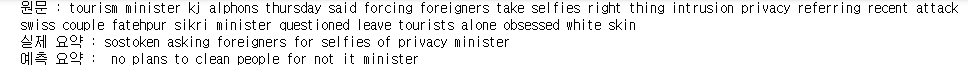
    - 원본 모델 결과 (위)
    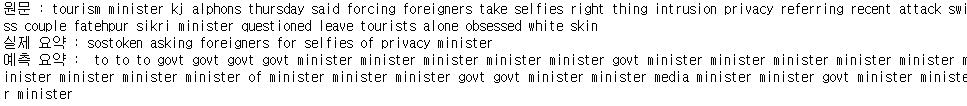
    - 3단 디코더 모델 결과 (위)
    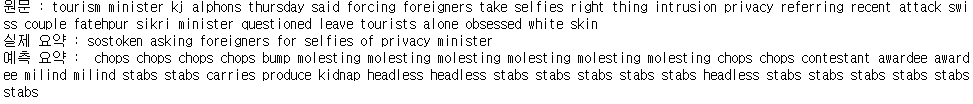
    - 3단 디코더, 3단 Z 모델 결과 (위)